# Random policy generation and analysis
Version: 2022-05-03 - Authors: Guillaume Dumas, Maximilian Puelma Touzel

Functions and plotting code that:
1. generates binary action policies of $N$ other agents according to either a mixture or sum of independent and identical parameters within teams with parametrzed correlation $\rho$.
- optionally computes the transition matrix in the number of 1s abstraction
2. evolves the deterministic joint policy map
3. computes agent-agent action correlations from joint action sequence produces in 2.

In [2]:
import numpy as np
from tqdm import tqdm, trange
import pylab as pl
from scipy.special import comb
from copy import deepcopy

In [2]:
def get_other_agent_policies(
    avg_pairwise_correlation,
    n_teams,
    team_size,
    agent_1_policy,
    policy_seed,
    gen_type="sum",
):
    n_agents = n_teams * team_size
    n_states = 2 ** (n_agents + 1)  # add states of agent 1
    joint_policy = np.zeros(n_states, dtype=int)

    rng = np.random.default_rng(policy_seed)
    agent_indices_bool = np.zeros(n_agents, dtype=bool)

    rho_normaldist = np.sin(np.pi / 2 * avg_pairwise_correlation)
    batch_size = np.min((int(2 ** 25), n_states))
    tmp_policies = np.zeros((n_agents, batch_size), dtype=bool)
    for batch_idx in range(int(n_states / batch_size)):
        for team in range(n_teams):
            agent_indices = range(team * team_size, (team + 1) * team_size)
            agent_indices_bool[agent_indices] = True

            if (
                gen_type == "mix"
            ):  # Bernoulli mixture of independent and identical binary RVs
                is_same = avg_pairwise_correlation > rng.random(batch_size)
                n_same = np.sum(is_same)
                n_diff = batch_size - n_same
                tmp_policies[np.ix_(agent_indices_bool, is_same)] = rng.integers(
                    0, 2, n_same
                )[np.newaxis, :]
                tmp_policies[np.ix_(agent_indices_bool, ~is_same)] = rng.integers(
                    0, 2, [team_size, n_diff]
                )
            elif (
                gen_type == "sum"
            ):  # signed sum of independent and identical normal RVs
                tmp_policies[agent_indices_bool, :] = (
                    np.sqrt(1 - rho_normaldist)
                    * rng.normal(size=(team_size, batch_size))
                    + np.sqrt(rho_normaldist)
                    * rng.normal(size=batch_size)[np.newaxis, :]
                ) > 0
            else:
                print("choose sum or mix")

            agent_indices_bool[agent_indices] = False
        joint_policy[
            batch_idx * batch_size : (batch_idx + 1) * batch_size
        ] = binary2index(
            np.vstack(
                (
                    agent_1_policy[
                        batch_idx * batch_size : (batch_idx + 1) * batch_size
                    ],
                    tmp_policies,
                )
            )
        )
    return joint_policy


def binary2index(var, n_all_agents=25):
    #     assert len(var) == n_all_agents, "incorrectly sized tuple"
    if var.ndim == 1:
        return np.sum(np.power(2, np.arange(len(var))) * var).astype(int)
    elif var.ndim == 2:
        return np.sum(
            np.power(2, np.arange(var.shape[0]))[:, np.newaxis] * var, axis=0
        ).astype(int)
    else:
        print("why more than 2 dimensions?")


def index2binary(var, n_all_agents=25):
    if np.isscalar(var):
        return (var & (1 << np.arange(n_all_agents))) > 0
    elif var.ndim == 1:
        return (var[np.newaxis, :] & (1 << np.arange(n_all_agents)[:, np.newaxis])) > 0
    else:
        print("why more than 1 dimensions?")
    # return np.fromstring(np.binary_repr(156,width=25), dtype=np.uint8)==49
    # return np.array([int(x) for x in list(("{0:0" + str(n_agents) + "b}").format(var))], dtype=bool)


def iterate_n_steps(joint_policy, initial_joint_action, n_steps):

    past_index = binary2index(initial_joint_action)
    index_seq = -np.ones(n_steps, dtype=np.int64)  # * np.nan  # generate the simulation
    last_time = n_steps - 1
    transient_duration = np.nan
    for t in range(n_steps):
        index_seq[t] = past_index
        past_index = joint_policy[past_index]
        if past_index in index_seq[: t + 1]:
            transient_duration = np.where(past_index == index_seq[: t + 1])[0][0]
            last_time = t
            break
    return index_seq, last_time, transient_duration


def get_corr_matrix(policies, index_seq):
    n_steps = len(index_seq)
    sims = policies[:, index_seq]
    n_agents = policies.shape[0]
    corr_matrix = np.zeros([n_agents] * 2)
    for i in range(n_agents):
        for j in range(n_agents):
            if i < j:
                corr_matrix[i, j] = 2 * np.sum(sims[i, :] == sims[j, :]) / n_steps - 1
    return corr_matrix + corr_matrix.T + np.identity(n_agents)


def simulate(
    policy,
    n_teams=2,
    team_size=12,
    n_steps=10000,
    n_corr_values=5,
    other_policies_seed=2,
    compute_all1s_abstraction=False,
    compute_transient_info=False,
    compute_corrmatrices=False,
):

    n_other_agents = n_teams * team_size
    n_all_agents = n_other_agents + 1
    n_states = 2 ** n_all_agents  # for binary actions

    corr_matrices = {}
    joint_prob_matrices = {}
    transient_and_period_store = {}
    binomvec = [tcomb(n_all_agents, k) for k in range(n_all_agents + 1)]
    Cind = np.insert(np.cumsum(binomvec), 0, 0)
    for rit in trange(n_corr_values + 1):
        rho = rit / n_corr_values
        data = []
        joint_store = []
        transient_store = []
        for gen_type in ("mix", "sum"):
            joint_policy = get_other_agent_policies(
                rho,
                n_teams,
                team_size,
                agent_1_policy,
                other_policies_seed,
                gen_type=gen_type,
            )

            if compute_all1s_abstraction:  # compute transition prob in C
                joint_Cprime_C = np.zeros((n_all_agents + 1, n_all_agents + 1))
                for C in range(n_all_agents + 1):
                    counts, bins = np.histogram(
                        policies[:, Cind[C] : Cind[C + 1] + 1].sum(axis=0),
                        bins=np.arange(0, n_all_agents + 2),
                    )
                    joint_Cprime_C[:, C] = counts
                joint_store.append(joint_Cprime_C)

            n_IC_seeds = 1000
            transient_and_period = np.zeros((n_IC_seeds, 2))
            for initial_state_seed in range(n_IC_seeds):
                rng = np.random.default_rng(initial_state_seed)
                initial_joint_action = rng.integers(0, 2, n_all_agents)

                index_seq, last_time, transient_duration = iterate_n_steps(
                    joint_policy, initial_joint_action, n_steps
                )

                if compute_transient_info:
                    if last_time < n_steps - 1:  # limit_cycle_detected
                        transient_and_period[initial_state_seed, 0] = transient_duration
                        transient_and_period[initial_state_seed, 1] = (
                            last_time - transient_duration
                        )

            #                 if compute_corrmatrices:
            #                     data.append(get_corr_matrix(policies, index_seq))

            transient_store.append(transient_and_period)
        if compute_corrmatrices:
            corr_matrices[rho] = data
        if compute_all1s_abstraction:
            joint_prob_matrices[rho] = joint_store
        if compute_transient_info:
            transient_and_period_store[rho] = transient_store

    out = []
    if compute_corrmatrices:
        out.append(corr_matrices)
    if compute_all1s_abstraction:
        out.append(joint_prob_matrices)
    if compute_transient_info:
        out.append(transient_and_period_store)
    return out


def tcomb(n, k):
    return comb(n, k, exact=True)

In [1]:
x = np.ones(2 ** 33, dtype=bool)

NameError: name 'np' is not defined

In [15]:
np.log10(x.itemsize * x.size)

9.030899869919436

In [100]:
%timeit np.sum(np.asarray([2 ** n for n in range(len(var))]) * var).astype(np.int64)

21.2 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [101]:
%timeit np.sum(np.power(2,np.arange(len(var))) * var).astype(np.int64)

9.28 µs ± 72.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [90]:
%timeit (1356 & (1 << np.arange(25) )) > 0

3.25 µs ± 12 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [94]:
%timeit np.array([int(x) for x in list(("{0:0" + str(25) + "b}").format(1356))], dtype=bool)

5.7 µs ± 28.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [95]:
%timeit np.fromstring(np.binary_repr(1356,width=25), dtype=np.uint8)==49

<magic-timeit>:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


3.79 µs ± 44.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Simulate

In [12]:
agent_1_seed = 1
rng = np.random.default_rng(agent_1_seed)
agent_1_policy = rng.integers(0, 2, 2 ** 25, dtype=bool)
# corr_matrices = simulate(agent_1_policy)
corr_matrices, joint_prob_matrices = simulate(
    agent_1_policy, compute_all1s_abstraction=True
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:49<00:00, 28.24s/it]


In [ ]:
fig, ax = pl.subplots(2, 6, figsize=(18, 6))
for rit, rho in enumerate(corr_matrices.keys()):
    ax[0, rit].set_title(f"rho={rho}")
    for cit, corr_matrix in enumerate(corr_matrices[rho]):
        ax[cit, rit].imshow(corr_matrix)
ax[0, 0].set_ylabel("Mixture dist.")
ax[1, 0].set_ylabel("Sum dist.")
# fig.savefig('corr_matrices.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [ ]:
n_other_agents = 30
rng = np.random.default_rng(agent_1_seed)
agent_1_policy = rng.integers(0, 2, 2 ** (n_other_agents + 1))
out = simulate(
    agent_1_policy,
    n_teams=2,
    team_size=int(n_other_agents / 2),
    compute_transient_info=True,
)

  0%|                                                                                                                                                                                        | 0/6 [00:00<?, ?it/s]


MemoryError: Unable to allocate 60.0 GiB for an array with shape (30, 2147483648) and data type bool

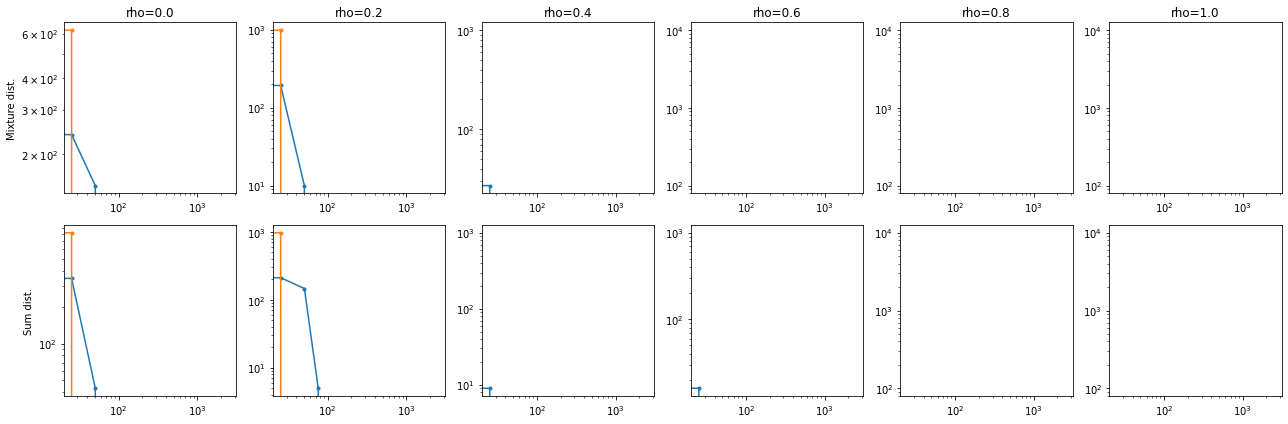

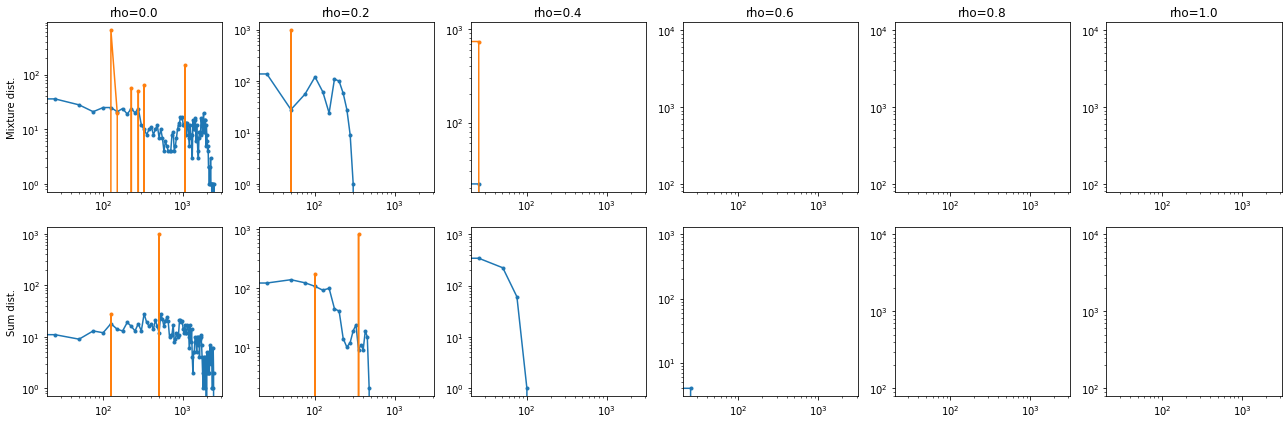

In [79]:
all_store = []
for n_other_agents in [10, 20, 30]:
    agent_1_seed = 1
    rng = np.random.default_rng(agent_1_seed)
    agent_1_policy = rng.integers(0, 2, 2 ** (n_other_agents + 1))
    # corr_matrices = simulate(agent_1_policy)
    out = simulate(
        agent_1_policy,
        n_teams=2,
        team_size=int(n_other_agents / 2),
        compute_transient_info=True,
    )
    transient_data = out[0]
    all_store.append(transient_data)
    fig, ax = pl.subplots(2, 6, figsize=(18, 6))
    n_steps = 10000
    for rit, rho in enumerate(transient_data.keys()):
        ax[0, rit].set_title(f"rho={rho}")
        for cit, data in enumerate(transient_data[rho]):
            for iit in range(2):
                counts, bins = np.histogram(
                    data[:, iit], bins=np.linspace(0, n_steps / 4, int(n_steps / 100))
                )
                ax[cit, rit].plot(bins[:-1], counts, ".-", color=f"C{iit}")
                ax[cit, rit].set_xscale("log")
                ax[cit, rit].set_yscale("log")
    ax[0, 0].set_ylabel("Mixture dist.")
    ax[1, 0].set_ylabel("Sum dist.")
    fig.tight_layout()

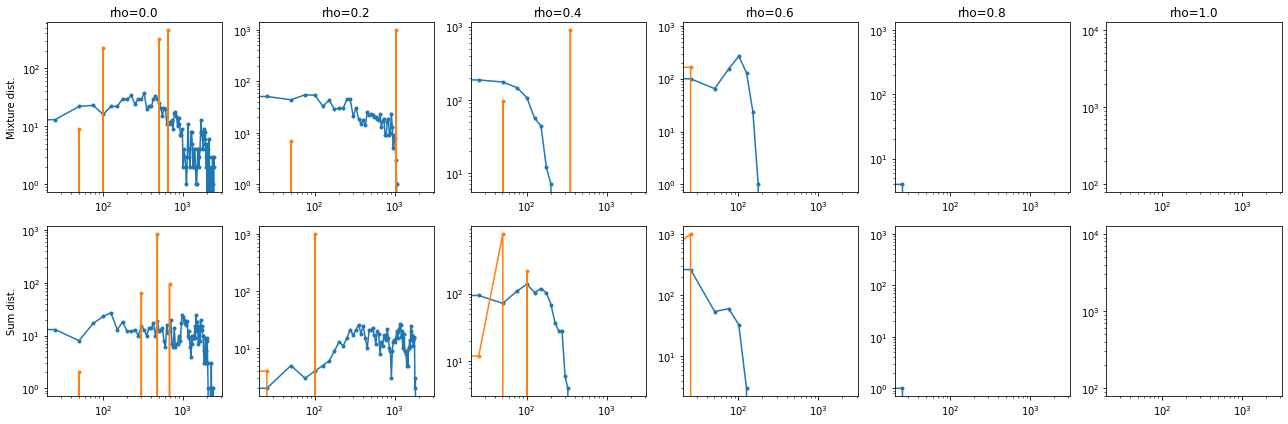

In [76]:
fig, ax = pl.subplots(2, 6, figsize=(18, 6))
n_steps = 10000
for rit, rho in enumerate(transient_data.keys()):
    ax[0, rit].set_title(f"rho={rho}")
    for cit, data in enumerate(transient_data[rho]):
        for iit in range(2):
            counts, bins = np.histogram(
                data[:, iit], bins=np.linspace(0, n_steps / 4, int(n_steps / 100))
            )
            ax[cit, rit].plot(bins[:-1], counts, ".-", color=f"C{iit}")
            ax[cit, rit].set_xscale("log")
            ax[cit, rit].set_yscale("log")
ax[0, 0].set_ylabel("Mixture dist.")
ax[1, 0].set_ylabel("Sum dist.")
fig.tight_layout()
# fig.savefig('corr_matrices.pdf', transparent=True,bbox_inches="tight",dpi=300)

Text(0, 0.5, 'Heterogeneous')

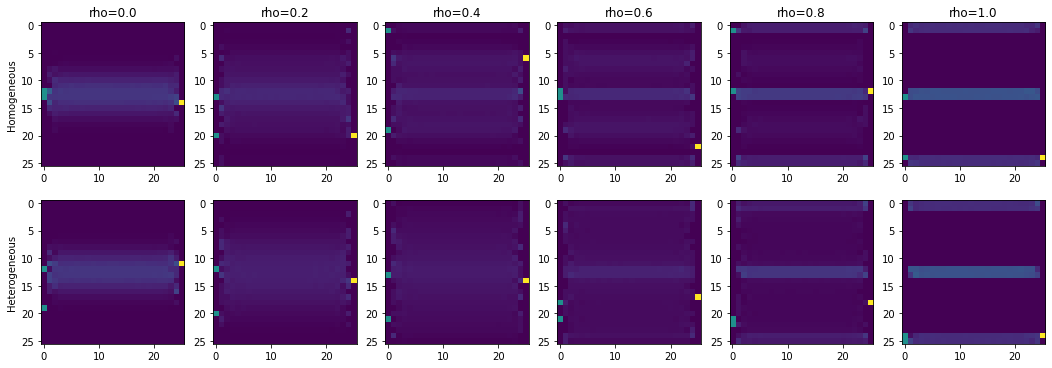

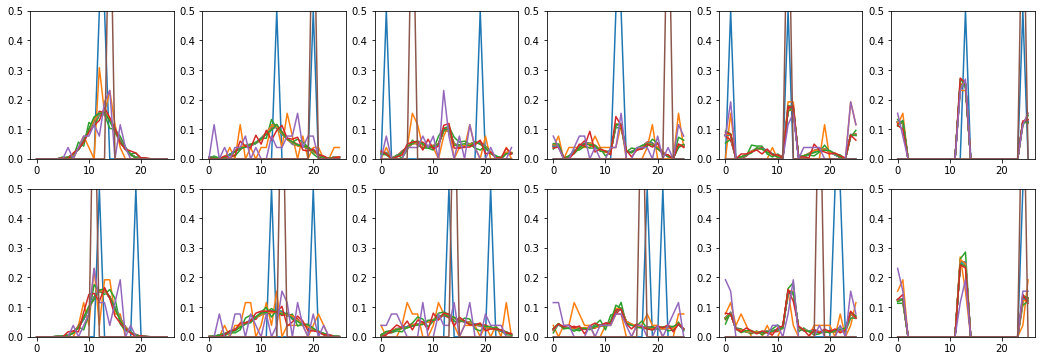

In [13]:
fig, ax = pl.subplots(2, 6, figsize=(18, 6))
fig2, ax2 = pl.subplots(2, 6, figsize=(18, 6))
for rit, rho in enumerate(joint_prob_matrices.keys()):
    ax[0, rit].set_title(f"rho={rho}")
    for cit, joint_matrix in enumerate(joint_prob_matrices[rho]):
        joint_matrix /= np.sum(joint_matrix)
        conditional_prob = joint_matrix / np.sum(joint_matrix, axis=0)[np.newaxis, :]
        ax[cit, rit].imshow(conditional_prob)
        ax2[cit, rit].plot(conditional_prob)
        ax2[cit, rit].set_ylim(0, 0.5)
ax[0, 0].set_ylabel("Homogeneous")
ax[1, 0].set_ylabel("Heterogeneous")

Count properties

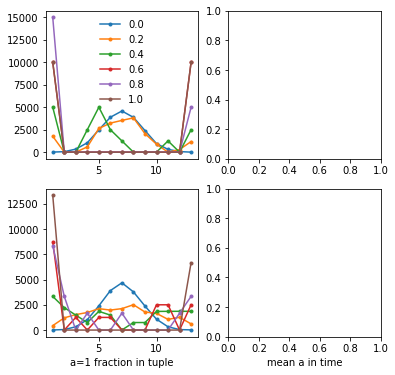

In [8]:
fig, ax = pl.subplots(2, 2, figsize=(6, 6))
for rit, rho in enumerate(joint_action_seqs.keys()):
    #     ax[0,rit].set_title(f'rho={rho}')
    for cit, data in enumerate(joint_action_seqs[rho]):
        counts, bins = np.histogram(
            np.sum(
                data.reshape([n_steps, n_teams, int(n_agents / n_teams)]), axis=2
            ).flatten(),
            np.arange(n_agents / n_teams + 2),
        )
        ax[cit, 0].plot(bins[1:], counts, ".-", label=f"{rho}")
#     for cit, data in enumerate(joint_action_seqs[rho]):
#         counts, bins=np.histogram(np.mean(data,axis=0),np.arange(n_agents+1)/n_agents)
#         ax[cit,1].plot(bins[1:],counts,'.-',label=f'{rho}')
#     for cit, data in enumerate(joint_action_seqs[rho]):
#         counts, bins=np.histogram(np.sum(data,axis=1),np.arange(n_agents+1))
#         ax[cit,0].plot(bins[1:]/n_agents,counts,'.-',label=f'{rho}')
#     for cit, data in enumerate(joint_action_seqs[rho]):
#         counts, bins=np.histogram(np.mean(data,axis=0),np.arange(n_agents+1)/n_agents)
#         ax[cit,1].plot(bins[1:],counts,'.-',label=f'{rho}')
ax[1, 0].set_xlabel("a=1 fraction in tuple")
ax[1, 1].set_xlabel("mean a in time")
ax[0, 0].legend(frameon=False)

In [18]:
# visualize the simulation
plt.figure(figsize=(50, 3))
plt.pcolor(sims.T)
plt.grid("on", color="k")
plt.tight_layout()
plt.savefig(f"{rho}.png")

NameError: name 'plt' is not defined

# Deprecated non-wrapped version

### Homogeneous case

Old method: (fixed fraction of actions)

In [3]:
# # initialize agents with random policies
# policies = np.zeros((n_agents, n_states))
# for agent in trange(n_agents):
#    policies[agent, :] = np.random.randint(0, n_actions, n_states)
# policies[0, :]
# # copy fraction of policies for each team
# team_size = int(n_agents/n_teams)
# n_similar_actions = int(n_states * beta)

# for team in trange(n_teams):
#     team_index = range(team * team_size, (team+1) * team_size)
#     similar_action_index = np.random.permutation(n_states)[:n_similar_actions]
#     for agent in team_index:
#         policies[agent, similar_action_index] = policies[team_index[0], :][similar_action_index]

# policies[team_index, :][:, similar_action_index].shape

New method: (variable fraction of actions, fixed mean)

In [4]:
policies = np.zeros((n_agents, n_states), dtype=bool)
team_size = int(n_agents / n_teams)
rng = np.random.default_rng(12345)
agent_indices_bool = np.zeros(n_agents, dtype=bool)
for team in trange(n_teams):
    agent_indices = range(team * team_size, (team + 1) * team_size)
    agent_indices_bool[agent_indices] = True
    # joint actions for a group are assigned as same over the group, else random
    is_same = avg_pairwise_correlation > rng.random(
        n_states
    )  # TODO: add more than binary ations
    #     is_same=(avg_pairwise_correlation>np.random.rand(0, n_actions, n_states)) #joint actions for a group are assigned as same over the group, else random
    n_same = np.sum(is_same)
    n_diff = n_states - n_same
    policies[np.ix_(agent_indices_bool, is_same)] = np.random.randint(
        0, n_actions, n_same
    )[np.newaxis, :]
    policies[np.ix_(agent_indices_bool, ~is_same)] = np.random.randint(
        0, n_actions, [team_size, n_diff]
    )
    agent_indices_bool[agent_indices] = False  # reset

100%|████████████████████████████████████████████| 5/5 [00:21<00:00,  4.20s/it]


### Heterogeneous case

In [5]:
policies = np.zeros((n_agents, n_states), dtype=bool)
team_size = int(n_agents / n_teams)
rng = np.random.default_rng(12345)
agent_indices_bool = np.zeros(n_agents, dtype=bool)
rho = np.sin(np.pi / 2 * avg_pairwise_correlation)
for team in trange(n_teams):
    agent_indices = range(team * team_size, (team + 1) * team_size)
    agent_indices_bool[agent_indices] = True
    policies[agent_indices_bool, :] = (
        np.sqrt(1 - rho) * rng.normal(size=(team_size, n_states))
        + np.sqrt(rho) * rng.normal(size=n_states)[np.newaxis, :]
    ) > 0
    agent_indices_bool[agent_indices] = False

100%|████████████████████████████████████████████| 5/5 [01:05<00:00, 13.17s/it]


## Simulation

In [7]:
def binary2index(var):
    return np.sum([2 ** n for n in range(n_agents * n_memory)] * var.flatten()).astype(
        int
    )


# initialize past with random actions
past_array = np.zeros((n_agents, n_memory))
for p in range(n_memory):
    past_array[:, p] = np.random.randint(0, n_actions, n_agents)
past_index = binary2index(past_array)
# generate the simulation
sims = np.zeros((n_steps, n_agents)) * np.nan
for t in trange(n_steps):
    sims[t, :] = policies[:, past_index]
    past_array[:, :-1] = past_array[:, 1:]
    past_array[:, -1] = sims[t, :]
    past_index = binary2index(past_array)

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 14821.85it/s]


## dataset analysis

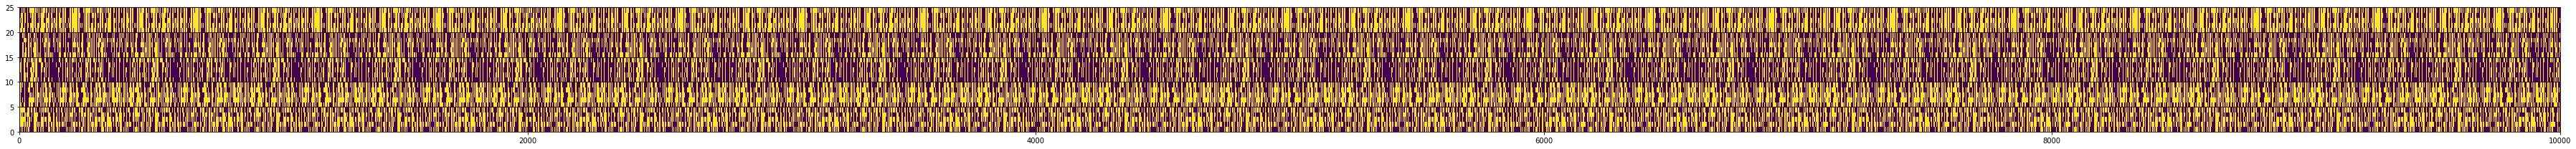

In [8]:
import matplotlib.pyplot as plt

# visualize the simulation
plt.figure(figsize=(50, 3))
plt.pcolor(sims.T)
plt.grid("on", color="k")
plt.tight_layout()
plt.savefig(f"{rho}.png")

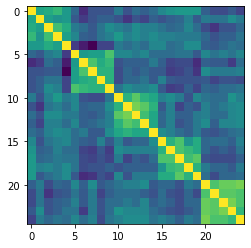

In [9]:
corr_matrix = np.zeros([n_agents] * 2)
for i in range(n_agents):
    for j in range(n_agents):
        if i < j:
            corr_matrix[i, j] = 2 * np.sum(sims[:, i] == sims[:, j]) / n_steps - 1
corr_matrix = corr_matrix + corr_matrix.T + np.identity(n_agents)
fig, ax = pl.subplots()
ax.imshow(corr_matrix)

# Junk

Homogeneous approach alternative:

In [14]:
import numpy as np
import math


def hb(p):
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p) if p > 0 and p < 1 else 0


def calca(nn, r):
    return (math.sqrt((1 - nn) * r ** 2 + (nn - 2) * r + 1) - r + 1) / r


def calcrho(nn, aa):
    return (nn + 2 * aa) / ((aa + 1) ** 2 + nn - 1)


def gen1(nn, aa):
    y = np.random.normal(0, 1, nn)
    return (np.sum(y) * np.ones(nn) + aa * y) / math.sqrt((aa + 1) ** 2 + (nn - 1))


def tryn(nn, rho, t):
    aa = calca(nn, rho)
    Pk = np.zeros((nn + 1, nn + 1))
    PJk = np.zeros((nn + 1, nn + 1))  # joint prob
    PCk = np.zeros((nn + 1, nn + 1))  # cond prob
    for _ in range(t):
        y = gen1(nn, aa)
        z = np.array([1 if t > 0 else 0 for t in y])
        c = 0
        for k in range(nn):
            c += z[k - 1] if k > 0 else 0
            Pk[k][c] += 1
            if z[k] == 1:
                PJk[k][c] += 1
    # normalize probabilities
    for k in range(nn):
        Pk[k] /= t
        PJk[k] /= t
    for k in range(nn):
        for c in range(k + 1):
            PCk[k][c] = PJk[k][c] / Pk[k][c] if Pk[k][c] > 0 else 0
    r = calcrho(nn, aa)
    #     print(f"{nn=} {r=} {aa=} {t=}")
    # print(np.round(Pk[:5,:5],5))
    # print(np.round(PJk[:5,:5],5))
    # print(np.round(PCk,5))
    H = np.zeros(nn)
    for k in range(nn):
        H[k] = 0
        for c in range(k + 1):
            H[k] += hb(PCk[k][c]) * Pk[k][c]
    print("h", np.round(H, 5))


rho = 0.7
nn = 12
tryn(nn, rho, 800000)

h [1.      0.81577 0.74309 0.70437 0.67853 0.66139 0.64927 0.63884 0.63239
 0.6242  0.62141 0.61609]


In [15]:
# old attempt at Homogeneous case

In [16]:
from scipy.special import comb


def tcomb(n, k):
    return comb(n, k, exact=False)

In [17]:
def tcomb(n, k):
    return comb(n, k, exact=False)


type(tcomb(1, 1))

numpy.float64

In [18]:
k = 0
r = 0
tcomb(k - 1, r) - ((-1) ** ((k + 2 * r - 1) / 2)) * tcomb(k - 1, (k - 1) / 2)

0j

In [19]:
def get_crk_arr(N):
    crk = np.zeros((N + 1, N + 1))
    for k in range(1, N + 1, 2):  # skip k=0 since gives 0 imaginary and is zero anyway
        for r in range(k + 1):
            crk[r, k] = tcomb(k - 1, r) - ((-1) ** ((k - 1) / 2 + r)) * tcomb(
                k - 1, (k - 1) / 2
            )
    return crk


def pkk_even(m, rho):
    return np.power(2 * np.pi, -m) / (1 + 2 * m * rho / (1 - rho))  # *np.sqrt(np.pi/2)


def pkk_odd(k, prk_arr, crk_arr):
    k = int(k)
    assert k % 2, "k not odd!"
    tmpsum = 0
    for r in range(int((k + 1) / 2), k):
        tmpsum += crk_arr[r, k] * prk_arr[r, k - 1]
    return ((-1) ** ((k - 1) / 2)) * (0.5 - tmpsum) / tcomb(k - 1, (k - 1) / 2)

In [20]:
N = 5
rho = 0.01
crk_arr = get_crk_arr(N)
prk_arr = np.zeros((N + 1, N + 1))
for k in range(N + 1):
    prk_arr[k, k] = pkk_odd(k, prk_arr, crk_arr) if k % 2 else pkk_even(k / 2, rho)
    for r in np.arange(k)[::-1]:
        prk_arr[r, k] = 1 / 2 if k == 1 else prk_arr[r, k - 1] - prk_arr[r + 1, k]
# test
for k in range(N + 1):
    print(np.sum(np.array([tcomb(k, r) for r in range(k + 1)]) * prk_arr[: k + 1, k]))

1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999


In [21]:
np.set_printoptions(linewidth=np.Inf)

In [22]:
1 % 2

1

In [23]:
prk_arr

array([[ 1.        ,  0.5       ,  0.15600336, -0.01599496,  0.0243466 ,  0.17085809],
       [ 0.        ,  0.5       ,  0.34399664,  0.17199832, -0.04034156, -0.14651149],
       [ 0.        ,  0.        ,  0.15600336,  0.17199832,  0.21233987,  0.10616994],
       [ 0.        ,  0.        ,  0.        , -0.01599496, -0.04034156,  0.10616994],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.0243466 , -0.14651149],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.17085809]])

In [24]:
entropy=np.sum(np.asarray[tcomb(k,r) for r in range(r)])*prk_arr[])

SyntaxError: invalid syntax (<ipython-input-24-d74236eea915>, line 1)

In [ ]:
k=3
tcomb(k,np.arange(1,k))